In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
#MNIST_IMAGES -> Tensors
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)

In [4]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
#Examine data
type(train_data)

torchvision.datasets.mnist.MNIST

In [8]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [9]:
image,label = train_data[0]

In [10]:
image.shape

torch.Size([1, 28, 28])

In [11]:
label

5

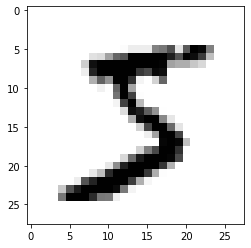

In [12]:
#Visualize it
plt.imshow(image.reshape((28,28)), cmap='gist_yarg') #viridis colour

In [13]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [14]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) #making spacing a bit wider (FORMATTING)

In [15]:
# First batch of images
for images, labels in train_loader:
    break

In [16]:
images.shape

torch.Size([100, 1, 28, 28])

In [17]:
labels.shape

torch.Size([100])

Labels:  [   4    6    2    3    4    0    9    5    0    1    6    9]


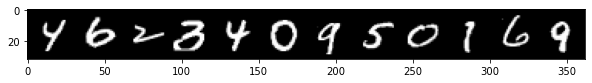

In [18]:
# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [19]:
#Model
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)
        
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X,dim=1)

In [20]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
# ANN ---> CNN
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [22]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [23]:
images.shape # -----> [100, 784]

torch.Size([100, 1, 28, 28])

In [24]:
images.view(100, -1).shape

torch.Size([100, 784])

In [25]:
import time

start_time = time.time()

#Training

epochs = 10

#Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for batch, (X_train, y_train) in enumerate(train_loader):
        batch+=1
        
        y_pred = model(X_train.view(100,-1))
        loss = criterion(y_pred, y_train)
        
        # last layers has 10 neurons that return [0.1, 0.0., ...] and return real predicted number
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch%200 == 0:
            acc = trn_corr.item()*100/(100*batch)
            print(f"Epoch: {i+1}, Batch: {batch}, Loss: {loss.item()}, Accuracy: {acc}")
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))
            
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
            
    val_loss = criterion(y_val, y_test)
    test_losses.append(val_loss)
    test_correct.append(tst_corr)


total_time = time.time() - start_time
print(f"Duration: {total_time/60}mins")

Epoch: 1, Batch: 200, Loss: 0.3094658851623535, Accuracy: 83.585
Epoch: 1, Batch: 400, Loss: 0.16791895031929016, Accuracy: 87.945
Epoch: 1, Batch: 600, Loss: 0.14138492941856384, Accuracy: 89.78833333333333
Epoch: 2, Batch: 200, Loss: 0.227959543466568, Accuracy: 94.96
Epoch: 2, Batch: 400, Loss: 0.25164881348609924, Accuracy: 95.1825
Epoch: 2, Batch: 600, Loss: 0.13384337723255157, Accuracy: 95.41833333333334
Epoch: 3, Batch: 200, Loss: 0.15869437158107758, Accuracy: 96.6
Epoch: 3, Batch: 400, Loss: 0.07899343222379684, Accuracy: 96.665
Epoch: 3, Batch: 600, Loss: 0.07815251499414444, Accuracy: 96.73833333333333
Epoch: 4, Batch: 200, Loss: 0.1500929296016693, Accuracy: 97.38
Epoch: 4, Batch: 400, Loss: 0.1955094188451767, Accuracy: 97.395
Epoch: 4, Batch: 600, Loss: 0.022083809599280357, Accuracy: 97.44833333333334
Epoch: 5, Batch: 200, Loss: 0.0728997066617012, Accuracy: 98.145
Epoch: 5, Batch: 400, Loss: 0.044582195580005646, Accuracy: 98.02
Epoch: 5, Batch: 600, Loss: 0.0720280408

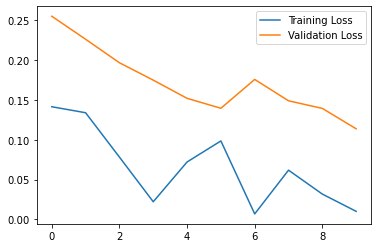

In [27]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.legend()

In [30]:
train_acc = [t/600 for t in train_correct]

In [32]:
test_acc = [t/100 for t in test_correct]

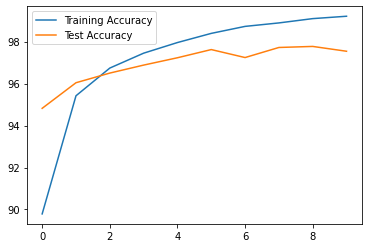

In [33]:
plt.plot(train_acc, label="Training Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.legend()

In [34]:
#New unseen data

test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [35]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test),-1))
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

In [38]:
total_acc = 100*correct.item()/(len(test_data))

In [39]:
total_acc

97.54

In [40]:
#Display confusion_matrix
confusion_matrix(predicted.view(-1), y_test.view(-1))

array([[ 972,    0,    5,    0,    1,    3,    4,    0,    8,    1],
       [   0, 1126,    2,    0,    0,    0,    3,    8,    0,    2],
       [   1,    3, 1015,   12,    1,    0,    2,   21,    8,    0],
       [   0,    1,    2,  973,    0,   11,    1,    0,    4,    1],
       [   2,    0,    3,    0,  964,    2,    9,    3,    5,    9],
       [   0,    0,    0,    2,    0,  863,    3,    0,    2,    1],
       [   1,    2,    0,    0,    5,    3,  935,    0,    1,    0],
       [   0,    0,    1,    4,    1,    1,    0,  977,    3,    1],
       [   3,    3,    4,    4,    0,    3,    1,    2,  936,    1],
       [   1,    0,    0,   15,   10,    6,    0,   17,    7,  993]])